Alfie
====


**Alfie:Democratising RGBA Image Generation With No $$$**

 * Paper: https://arxiv.org/pdf/2408.14826v1

![Alfie Overview](../assets/alfie_overview.png)


### Instalation

```bash
git clone https://github.com/aimagelab/Alfie.git
cd Alfie

pip install torch torchvision
pip install -r requirements.txt
```

In [2]:
import sys
sys.path.append("Alfie")
import json
import ast

import matplotlib.pyplot as plt
import torch
from transformers import VitMatteImageProcessor, VitMatteForImageMatting
from accelerate import PartialState
from accelerate.logging import get_logger
from accelerate.utils import set_seed

from settings import parse_setting
from alfie.generate import get_pipe
#base_arg_parser, parse_bool_args
from alfie.grabcut import grabcut, save_rgba

from alfie.trimap import compute_trimap
from alfie.utils import normalize_masks

torch.backends.cuda.matmul.allow_tf32 = True

SETTING_NAME = "centering-rgba-alfie"
settings_dict = parse_setting(SETTING_NAME)
print()
settings_dict = {
    k: v == "True"
    for k, v in settings_dict.items()
}

settings_dict

{'centering': True,
 'use_neg_prompt': True,
 'exclude_generic_nouns': True,
 'cutout_model': False,
 'use_suffix': False}

In [3]:
distributed_state = PartialState()
device = distributed_state.device
print(device)

IMAGE_SIZE = 512
SCHEDULER = 'euler'  # choices=['euler', 'euler_ancestral']

pipe = get_pipe(
    image_size=IMAGE_SIZE,
    scheduler=SCHEDULER,
    device=device
)
pipe

cuda


Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.75it/s]
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Loading pipeline components...: 100%|██████████| 5/5 [00:00<00:00, 137.03it/s]


PixArtSigmaPipeline {
  "_class_name": "PixArtSigmaPipeline",
  "_diffusers_version": "0.29.2",
  "_name_or_path": "PixArt-alpha/PixArt-Sigma-XL-2-1024-MS",
  "scheduler": [
    "diffusers",
    "EulerDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "T5EncoderModel"
  ],
  "tokenizer": [
    "transformers",
    "T5Tokenizer"
  ],
  "transformer": [
    "alfie.transformer_2d",
    "Transformer2DModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [4]:
def build_prompt(fg_prompt, centering, use_suffix):
    suffix = ' on a white background'
    prompt_complete = ["A white background", fg_prompt]
    prompt_full = ' '.join(prompt_complete[1].split())
    prompt = prompt_complete if centering else prompt_complete[1]
    if use_suffix:
        prompt += suffix
    return prompt


NOUNS_TO_EXCLUDE = [
    'image', 'images', 'picture', 'pictures', 'photo', 'photograph', 'photographs', 'illustration',
    'paintings', 'drawing', 'drawings', 'sketch', 'sketches', 'art', 'arts', 'artwork', 'artworks',
    'poster', 'posters', 'cover', 'covers', 'collage', 'collages', 'design', 'designs', 'graphic', 'graphics',
    'logo', 'logos', 'icon', 'icons', 'symbol', 'symbols', 'emblem', 'emblems', 'badge', 'badges', 'stamp',
    'stamps', 'img', 'video', 'videos', 'clip', 'clips', 'film', 'films', 'movie', 'movies', 'meme', 'grand', 
    'sticker', 'stickers', 'banner', 'banners', 'billboard', 'billboards', 'label', 'labels', 'scene', 'art',
    'png', 'jpg', 'jpeg', 'gif', 'www', 'com', 'net', 'org', 'http', 'https', 'html', 'css', 'js', 'php', 
    'scene', 'view', 'm3'
]

USE_NEGATIVE_PROMPT = True
NEGATIVE_PROMPT = ["Blurry, shadow, low-resolution, low-quality"] if USE_NEGATIVE_PROMPT else None
prompt = build_prompt(
    fg_prompt="A photo of a cat playing with a kite",
    centering=settings_dict['centering'],
    use_suffix=settings_dict['use_suffix']
)
print(f"Prompt: {prompt}")

Prompt: ['A white background', 'A photo of a cat playing with a kite']


100%|██████████| 30/30 [00:03<00:00,  8.37it/s]


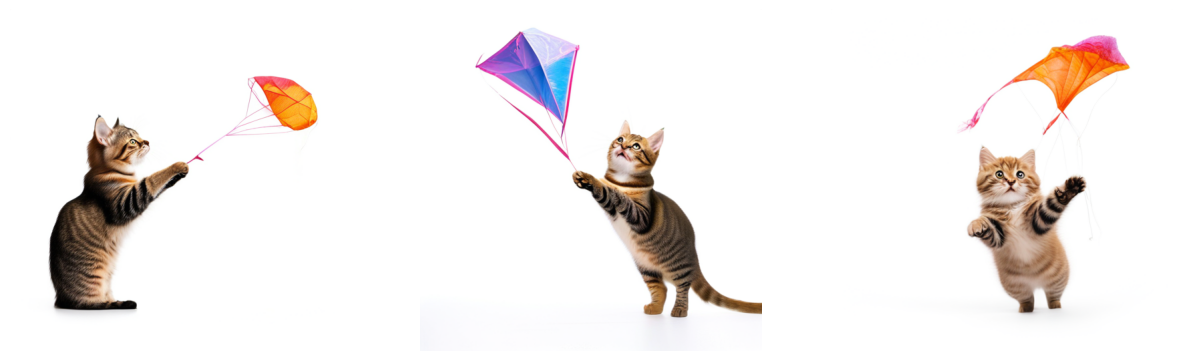

In [5]:
SEED = 123
NUM_IMAGES = 3
STEPS= 30


fig, axes = plt.subplots(1, NUM_IMAGES, figsize=(NUM_IMAGES * 5, 5))

for i, seed in enumerate(range(SEED, SEED + NUM_IMAGES)):
    set_seed(seed)
    generator = torch.Generator(device="cuda").manual_seed(seed)

    images, heatmaps = pipe(
        prompt=prompt,
        negative_prompt=NEGATIVE_PROMPT,
        nouns_to_exclude=NOUNS_TO_EXCLUDE,
        keep_cross_attention_maps=True,
        return_dict=False,
        num_inference_steps=STEPS,
        centering=["centering"],
        generator=generator
    )
    
    image = images[0]
    torch.cuda.empty_cache()
    axes[i].imshow(image)
    axes[i].axis('off')
    
plt.show()